# HiRISENet-Tiny

A tiny neural network classifier for Mars HiRISE images

## Introduction

The Mars HiRISE (High Resolution Imaging Science Experiment) [[1]](#1) is a camera on board the Mars Reconnaissance
Orbiter which has been orbiting and studying Mars since 2006. A product of this payload's years of service has been the
curation of the Mars orbital image (HiRISE) labeled data set [[2]](#2) by NASA. This dataset provides a curated set of
labelled images of the Martian terrain from an orbital perspective. **Figure 1** shows one of the first images taken
with the HiRISE camera.

<!--- Public Domain, https://commons.wikimedia.org/w/index.php?curid=656514 >
--->
![First HiRISE Image](../assets/images/mro_first_image.jpg "Figure 1. The first orbital image captured by HiRISE")

**Figure 1. Crop of one of the first images of Mars from the HiRISE camera.**

In 2018, Wagstaff et. al. [[3]](#3) set out to train a deep learning model to enable scientists & researchers to conduct
advanced queries of the HiRISE data in NASA's planetary imagery database. With the first edition of the dataset, the
authors fine-tuned the AlexNet convolutional neural network on the data. This initial dataset contained 3,820 
greyscale images and consisted of the labels crater, dark dune, bright dune, dark slope streak, other and edge. With
this dataset, the model achieved 99.1%, 88.1%, and 90.6% accuracy across their training, validation, and test sets
respectively.

Following this effort, Wagstaff et. al. published a follow up paper [[4]](#4) which expanded the initial dataset to
a version 3.2. This expanded dataset consists of a total of 64,947 landmark images. These images have been preprocessed
and cropped to a 227x227 size similar to the first edition. In v3.2, a subset of these images, 9,022, were augmented 
using a variety of image augmentation techniques applied individually to the subset of images. This artificially
expanded the available data. The authors also introduced the classes impact ejecta, spiders, and swiss cheese while
removing edge.

![HiRISE v3.2 Class Imagse](../assets/images/hirise_v3_classes.png)

The authors also fine-tuned the AlexNet model on the new dataset. For this iteration, the authors analyzed the model's
confidence and utilized calibration techniques to make the model more reliable. With this approach and improved dataset,
the authors managed to improve the model's classification accuracy to
{"train": 99.6%, "val": 88.6%, "test": 92.8%}.

![Dataset Class Distribution](../assets/images/hirise_dataset_class_distribution.png)

An important thing to note is that the class distribution is pretty unbalanced. Images of "Other" significantly
dominate the dataset while "Impact Ejecta" constitutes a small portion of the dataset.

### About this Project

In this project I challenged myself to create a training pipeline for a simple
neural network model. My goal is to learn how to train a machine learning model.

## Setup

Lets get some basic project infrastructure set up first.

In [5]:
import sys

sys.path.append("data")
sys.path.append("utils")

In [6]:
import torch
from utils.gpu_management import GPUManager

from data.dataset import HiRISE
from data.split_type import SplitType
import torchvision
from torchvision.transforms import v2
from pathlib import Path
from model import insights
from model.efficientnet.download import download_efficientnet_lite, EfficientNetVariant
from model.training import train_model, test_model
import torchinfo

torch.manual_seed(42)

device = GPUManager.enable_gpu_if_available()

if device.type == "cuda":
    GPUManager.cleanup_gpu_cache()

__CUDA VERSION: 90100
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA RTX A2000 8GB Laptop GPU
__CUDA Device Total Memory [GB]: 8.58947584


### Exploratory Data Analysis

The first thing we should do is gain a deep understanding of our dataset. As
mentioned in the introduction, the model we train is a direct reflection of our
data. That is, the model _is_ the data.

The HiRISE v3.2 [[2]](#2) dataset has the following characteristics:

* **Number of Classes:** The dataset comprises of 8 different classes, each representing different Martian terrain features: bright dune, crater, dark dune, impact ejecta, other, slope streak, spider, swiss cheese.

* **Images:** The dataset contains 64,947 227x227 images. The images have been pre-processed and a subset of the original images were augmented with the following transformations: 90° clockwise rotation, 180° clockwise rotation, 270° clockwise rotation, horizontal flip, vertical flip, random brightness adjustment.

* **File Format:** The images are stored in JPG format.

* **Directory Structure:** The data has been split by the authors into a training, validation, and test split.

Before we can feed our dataset into a model, we need to transform it into a
format that the model can understand. For this, we use the `transforms` module
from `torchvision`.

In [7]:
image_size: tuple[int, int] = (227, 227)

data_transforms = {
    SplitType.TRAIN: v2.Compose(
        [
            v2.Resize(image_size),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
        ]
    ),
    SplitType.VAL: torchvision.transforms.v2.Compose(
        [
            v2.Resize(image_size),
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
        ]
    ),
    SplitType.TEST: torchvision.transforms.v2.Compose(
        [v2.Resize(image_size), v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]
    ),
}

At this point, the transforms I use are pretty standard for image data.
We first resize each image to 227x227. The images should already be this size
but you can never be too careful. The `v2.ToImage()` and `v2.ToDtype(...)`
are the new PyTorch v2 recommended way of transforming an image to a tensor.
The old `ToTensor()` is deprecates as of this writing.

I also opted to skip any augmentations in this project. The authors of the
dataset already provide some augmented images and I wanted to keep the working
copy as close to the original as possible.

From what I've read, higher resolution images provides more pixels or
features for a neural network to chew and nitpick on. Thus, increasing the
learning capacity of the model. However, this also increases the storage size of the
images themselves and the computational costs of the model. On resource-constrained
spacecraft where everything has a constraint and a limited budget, that presents
a challenge. 

In [8]:
data_folder: Path = Path("/tmp/.hirise")

train_dataset = HiRISE(
    root_dir=data_folder,
    split_type=SplitType.TRAIN,
    transform=data_transforms[SplitType.TRAIN],
    target_transform=lambda data: torch.tensor(data, dtype=torch.long),
    download=True,
)

val_dataset = HiRISE(
    root_dir=data_folder,
    split_type=SplitType.VAL,
    transform=data_transforms[SplitType.VAL],
    target_transform=lambda data: torch.tensor(data, dtype=torch.long),
    download=True,
)

test_dataset = HiRISE(
    root_dir=data_folder,
    split_type=SplitType.TEST,
    transform=data_transforms[SplitType.TEST],
    target_transform=lambda data: torch.tensor(data, dtype=torch.long),
    download=True,
)

https://zenodo.org/api/records/4002935/files/hirise-map-proj-v3_2.zip/content: 100%|██████████| 869M/869M [02:11<00:00, 6.91MB/s]  


Now that we have our datasets, lets see what these images actually look like.
Lets plot one of each class.

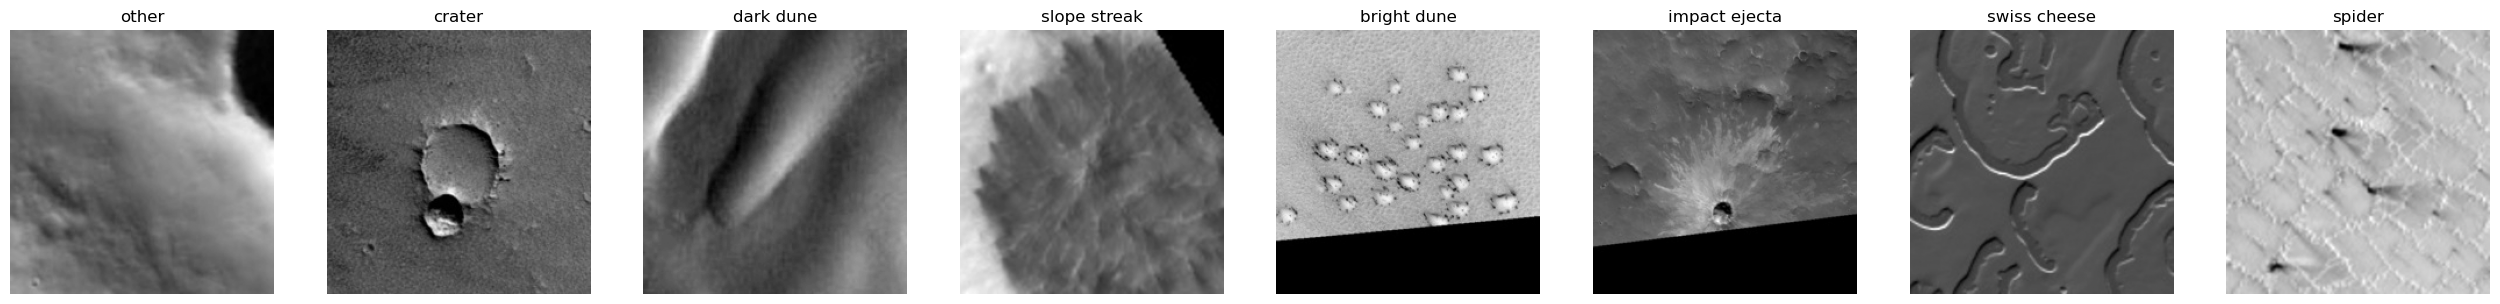

In [9]:
train_dataset.show_image_per_class()

From the images we show, it's clear that some of these terrains are very
similar to each other. Two particular classes that stand out to me are the
crater and impact ejecta. They both look like craters with the distinguishing
feature being the brighter material surrounding the impact crater. 

It also seems like a crater in this dataset is an impact zone that is larger
than an impact ejecta image. So then, what if the impact ejecta has been covered
or eroded in the image? I wonder if the model will have some difficulties with
that.

As mentioned by the authors of the dataset, the "other" class is a catch-all
class to capture anything that doesn't quite fit into the other classes. They
also mention that this "other" class makes up the overwhelming majority of the
data.

Lets take a look at that now.

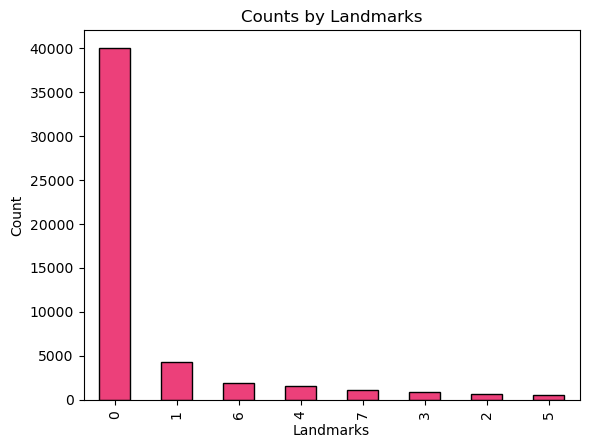

In [10]:
train_dataset.show_class_distribution()

From the distribution plot we can see that the "Other" landmarks significantly
dominate the class distribution. This clear imbalance of data will need to be
accounted for in our model training.

### Selecting Our Models

As a spacecraft engineer, I prefer ol' reliable over novelty. Therefore, in this
project I have opted for convolutional neural networks since they are a more
mature and well understood architecture than something like a vision transformer.
Additionally, I want a pre-trained model that will facilitate doing things like
transfer learning which is useful in space since we have very small or
non-existent datasets.

I did some initial literature review by comparing AlexNet, ResNet18 [[6]](#6),
EfficientNet [[7]](#7), and ConvNeXt [[8]](#8) and found that EfficientNet was
a modern and small CNN architecture that met my needs.

One last thing I identified when selecting some of these architectures was that
they all expect three channel input images (RGB) but our dataset consists of
single-channel greyscale images. Thus, I had to modify the input layer of each
model to account for this discrepancy. Lastly, I modified the final layer of
each model which does the actual class prediction from IMAGENET's 1,000 classes
to our humble 8 classes.

#### EfficientNet

To get more performance out of a neural network, machine learning practitioners
would typically scale up the network across a dimension. They'd either add
more layers making the model deeper. Or they'd increase the resolution of the
model. Most of these efforts were at best trial-and-error and at worst random.

![Model Scaling with EfficientNet](../assets/images/model_scaling.png)

Researchers at Google set out to create a methodical approach to scaling up
neural networks. They wanted to consider scaling across all dimensions instead
of one or a subset. Using
[neural architecture search](https://en.wikipedia.org/wiki/Neural_architecture_search),
the authors generated a family of models they named EfficientNet. The model
employs some neat tricks like depth-wise separable convolutions and inverted
residual blocks which makes the network more efficient by requiring fewer
computations and parameters.

In this project, we will be utilizing the EfficientNet-Lite variant which is
optimized for mobile & edge deployments. Specifically, we wil look at
efficientnet-lite0, the smallest offering. You can see more details 
[here](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet/lite)

In [11]:
model = download_efficientnet_lite(EfficientNetVariant.Lite0)

https://github.com/RangiLyu/EfficientNet-Lite/releases/download/v1.0/efficientnet_lite0.pth: 100%|██████████| 18.0M/18.0M [00:00<00:00, 22.5MB/s]


In [12]:
model.eval()
torchinfo.summary(model, input_size=(1, 1, 227, 227))

Layer (type:depth-idx)                   Output Shape              Param #
EfficientNetLite                         [1, 8]                    --
├─Sequential: 1-1                        [1, 32, 114, 114]         --
│    └─Conv2d: 2-1                       [1, 32, 114, 114]         320
│    └─BatchNorm2d: 2-2                  [1, 32, 114, 114]         64
│    └─ReLU6: 2-3                        [1, 32, 114, 114]         --
├─ModuleList: 1-2                        --                        --
│    └─ModuleList: 2-4                   --                        --
│    │    └─MBConvBlock: 3-1             [1, 16, 114, 114]         896
│    └─ModuleList: 2-5                   --                        --
│    │    └─MBConvBlock: 3-2             [1, 24, 57, 57]           5,136
│    │    └─MBConvBlock: 3-3             [1, 24, 57, 57]           8,832
│    └─ModuleList: 2-6                   --                        --
│    │    └─MBConvBlock: 3-4             [1, 40, 29, 29]           13,472
│  

### Measuring Model Properties

With our model architecture selected and modified for HiRISE, we are now ready
to do some profiling to identify which models meet our project requirements.

Now, I want to put a disclaimer here. Since this model is going to deployed to
real hardware, there is **nothing** that can replace the insights and understanding
gained through evaluating the model performance on the target hardware. In
spaceflight software, this is broken down into two general categories:

1. Processor-in-the-Loop (PIL) Testing: Test the flight software on the flight processor.
2. Hardware-in-the-Loop (HIL) Testing: Test the flight software on the flight processor and other flight peripherals.

Ultimately, this comes down to the age old spaceflight mantra "test like you
fly, and fly like you test".

So eventually I will be doing model performance evaluation on the target
hardware. Testing on the laptop just provides a quick and dirty estimate on
what to expect.

#### Model Sizes

Lets take a look at the size of our model.

In [13]:
insights.model_size(model)

model size: 13.057 MB


Wow! Now that is a pretty tiny model. 

#### FLOPS

Next, lets calculate the number of floating-point operations (FLOPS) that our
model executes. FLOPS are an important metric to capture as they provide some
insights into the computational and energy requirements of the model.
Additionally for spacecraft flight software, a general rule of thumb is that the
less floating-point operations you do the better. That's because floating-point
math is computationally expensive and consumes a lot of energy.

In [14]:
insights.flops(model)

881682304

#### Inference Latency

Calculating the inference latency of a neural network can be pretty tricky.
Apart from the hardware, the initial runs of a model can be slower due to things
like cache warming. It's good practice to do some initial warm-up runs to get
better measurements. Additionally, we will calculate the average latency over
a handful of iterations to get a closer estimate.

For characterizing the inference time on GPU, we must synchronize the GPU to
ensure all operations have completed before stopping the timer.

In [15]:
dummy_img = torch.unsqueeze(train_dataset[0][0], 0)

insights.inference_latency(model, dummy_img)

Average CPU inference time with warm-up: 0.0093 seconds
Average GPU Inference time with GPU synchronization and warm-up: 0.0048 seconds


### Establishing a Baseline

With our models downloaded, modified and prepared, we are ready to jump into
training and establishing a baseline. Our objective in this first round of
training is to identify the best performing models so that we can downselect
from our set of models. Thereafter, we shall improve the model performance by
introducing data augmentations and fiddling with the hyperparameters.

First, we'll setup some hyperparameters
for this round of training.

In [16]:
LEARNING_RATE: float = 1e-3
BATCH_SIZE: int = 96  # Just the largest batch I could fit on my laptop's GPU
EPOCHS: int = 10

We'll also need to create a couple of `DataLoader` objects to easily iterate
over our datasets.

In [17]:
dataloaders = {
    name: torch.utils.data.DataLoader(
        dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True
    )
    for name, dataset in zip(
        [SplitType.TRAIN, SplitType.VAL, SplitType.TEST],
        [train_dataset, val_dataset, test_dataset],
    )
}

For the loss function we will use `CrossEntropyLoss`. This is a fairly standard
loss function and is commonly used in machine learning. Similarly, the `Adam`
and `AdamW` optimizers are fairly standard and a good go-to default optimizer
for training deep learning models.

In [18]:
criterion = torch.nn.CrossEntropyLoss()

optimizer: torch.optim.Optimizer = torch.optim.AdamW(
    params=model.parameters(), lr=LEARNING_RATE
)

In [19]:
model, efficientnet_history = train_model(
    model,
    dataloaders,
    criterion,
    optimizer,
    None,
    device,
    num_epochs=EPOCHS,
)

Epoch 0/9: Train Loss: 0.1757, Acc: 0.9428, Val Loss: 0.4701, Acc: 0.8870
Epoch 1/9: Train Loss: 0.0822, Acc: 0.9701, Val Loss: 0.4793, Acc: 0.8932
Epoch 2/9: Train Loss: 0.0645, Acc: 0.9776, Val Loss: 0.6559, Acc: 0.8868
Epoch 3/9: Train Loss: 0.0455, Acc: 0.9845, Val Loss: 0.6845, Acc: 0.8876
Epoch 4/9: Train Loss: 0.0398, Acc: 0.9859, Val Loss: 0.4650, Acc: 0.9041
Epoch 5/9: Train Loss: 0.0318, Acc: 0.9897, Val Loss: 0.4385, Acc: 0.9003
Epoch 6/9: Train Loss: 0.0296, Acc: 0.9899, Val Loss: 0.5453, Acc: 0.8917
Epoch 7/9: Train Loss: 0.0306, Acc: 0.9901, Val Loss: 0.4245, Acc: 0.9050
Epoch 8/9: Train Loss: 0.0232, Acc: 0.9924, Val Loss: 0.6996, Acc: 0.8920


### Testing the Model

With our model now trained, lets test it on our hold out test set split.

In [ ]:
test_acc: float = test_model(model, dataloaders[SplitType.TEST], device)

test_acc

Our small model achieves some pretty good accuracy on the hold out test set.
With our model fully trained now, lets move onto actually deploying it.

## Deployment

#### Export to File

The first thing we will do is serialize our model to a file using PyTorch 2's
`torch.export` function. We will also export the model using legacy PyTorch's
`torch.save` so that others can load the pickled model.

As of this writing, the new ExecuTorch library from PyTorch 2.X does not support
execution on the GPU. For our use case we want to run our model on both CPU
and GPU. Therefore, we will use the legacy TorchScript library to export and
run our model on the NVIDIA Jetson Nano. However, we also want to be forward
thinking and also export our model to the new PyTorch 2 formats.

In [ ]:
with torch.no_grad():
    model.eval()
    model = model.to("cpu")

    example_args = (torch.randn((1, 1, 227, 227), dtype=torch.float32),)

    # Export to PyTorch 2
    exported_program = torch.export.export(model, example_args)

    torch.export.save(
        exported_program, "/workspace/model/efficientnet_lite0_hirise.pt2"
    )

    # Export the state dictionary
    torch.save(
        model.state_dict(), "/workspace/model/efficientnet_lite0_hirise_state_dict.pt"
    )

## Future Work

- Consider model calibration techniques similar to what the HiRISE authors did.
- Test quantization-aware-training which results in better accuracy compared to post-training quantization.

-------------------------------------

## References

<a id="1">[1]</a> 
Wikipedia contributors. (2024, November 19). HiRISE. Wikipedia. https://en.wikipedia.org/wiki/HiRISE

<a id="2">[2]</a> 
Gary Doran, Emily Dunkel, Steven Lu, & Kiri Wagstaff. (2020). Mars orbital image (HiRISE) labeled data set version 3.2 (3.2.0) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.4002935

<a id="3">[3]</a>
Wagstaff, K., Lu, Y., Stanboli, A., Grimes, K., Gowda, T., & Padams, J. (2018). Deep Mars: CNN Classification of Mars Imagery for the PDS Imaging Atlas. Proceedings of the AAAI Conference on Artificial Intelligence, 32(1). https://doi.org/10.1609/aaai.v32i1.11404

<a id="4">[4]</a>
Wagstaff, Kiri, et al. Mars Image Content Classification: Three Years of NASA Deployment and Recent Advances. arXiv:2102.05011, arXiv, 9 Feb. 2021. arXiv.org, https://doi.org/10.48550/arXiv.2102.05011.

<a id="5">[5]</a>
Dunkel, Emily R., et al. “Benchmarking Deep Learning Models on Myriad and Snapdragon Processors for Space Applications.” Journal of Aerospace Information Systems, vol. 20, no. 10, Oct. 2023, pp. 660–74. DOI.org (Crossref), https://doi.org/10.2514/1.I011216.

<a id="6">[6]</a>
He, Kaiming, et al. Deep Residual Learning for Image Recognition. arXiv:1512.03385, arXiv, 10 Dec. 2015. arXiv.org, https://doi.org/10.48550/arXiv.1512.03385.

<a id="7">[7]</a>
Tan, Mingxing, and Quoc V. Le. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. arXiv:1905.11946, arXiv, 11 Sept. 2020. arXiv.org, https://doi.org/10.48550/arXiv.1905.11946.

<a id="8">[8]</a>
Liu, Zhuang, et al. A ConvNet for the 2020s. arXiv:2201.03545, arXiv, 2 Mar. 2022. arXiv.org, https://doi.org/10.48550/arXiv.2201.03545.
